# rs-embed Demo: All-Model Embedding + Crop Yield Regression (Illinois)

This notebook runs a complete end-to-end pipeline:
1. Build maize samples in Illinois from SPAM grids.
2. Build labels from SPAM yield (`Y_TA`).
3. Auto-plan embedding export for **all registered models** (backend/temporal aware).
4. Export/read multi-model embeddings.
5. Run crop-yield regression and compare model performance.


## 0. Dependency and Operating Instructions

Suggested environment:
- `rs-embed` has been installed
- Available GEE authentication (`ee.Initialize()`)
- Local presence:
  - `spam2020V2r0_global_yield/spam2020V2r0_global_H_TA.csv`
  - `spam2020V2r0_global_yield/spam2020V2r0_global_Y_TA.csv`

Download: SPAM2020 CROP Dataset[1]
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/SWPENT

[1] International Food Policy Research Institute (IFPRI), 2024, "Global Spatially-Disaggregated Crop Production Statistics Data for 2020 Version 2.0", https://doi.org/10.7910/DVN/SWPENT, Harvard Dataverse, V4

Default parameters:
- Crop column: `SPAM_CROP_COL=MAIZ_A`
- Area threshold: `MAIZ_AREA_MIN_HA=2500`
- Region: `US / United States of America / Illinois`
- Label year: `SPAM_LABEL_YEAR=2020`
- Image window: `EMBED_START=2019-06-01`, `EMBED_END=2019-08-31`

If you are running GEE for the first time:
- You may need to execute `ee.Authenticate()` first, followed by `ee.Initialize()`.


In [5]:
import os
import time
import warnings
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import ee
except Exception:
    ee = None

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from rs_embed import PointBuffer, TemporalSpec, OutputSpec 
from rs_embed.api import export_batch
from rs_embed.core.registry import list_models, get_embedder_cls
from rs_embed.embedders.catalog import MODEL_SPECS

from examples.plot_utils import inspect_export_npz
from examples.utils_demo import _ee_initialize, _rings_from_geom_info

warnings.filterwarnings("ignore")
np.random.seed(42)

# Demo defaults (used across later cells)
BUFFER_M = 2000
LABEL_YEAR = int(os.getenv("SPAM_LABEL_YEAR", "2020"))
EMBED_START = os.getenv("EMBED_START", "2019-06-01")
EMBED_END = os.getenv("EMBED_END", "2019-08-31")

SPAM_CROP_COL = os.getenv("SPAM_CROP_COL", "MAIZ_A").upper()
MAIZ_AREA_MIN_HA = float(os.getenv("MAIZ_AREA_MIN_HA", "2500"))
SPAM_COUNTRY_CODE = os.getenv("SPAM_COUNTRY_CODE", "US").upper()
SPAM_COUNTRY = os.getenv("SPAM_COUNTRY", "United States of America")
SPAM_STATE = os.getenv("SPAM_STATE", "Illinois")

PRIMARY_REGRESSOR = os.getenv("PRIMARY_REGRESSOR", "rf").strip().lower()
MIN_MODEL_SAMPLES = int(os.getenv("MIN_MODEL_SAMPLES", "80"))
TEST_SIZE = float(os.getenv("REG_TEST_SIZE", "0.25"))


EE_PROJECT = os.getenv("EE_PROJECT")



## 1. Initialize GEE and extract the boundary of Illinois


In [6]:
if ee is None:
    print("earthengine-api not installed; Illinois boundary plot will be skipped.")
    roi_geom = None
    center_lon, center_lat = np.nan, np.nan
else:
    try:
        _ee_initialize(ee, EE_PROJECT)
    except Exception as e:
        print("ee.Initialize() failed:", e)
        print("Trying ee.Authenticate() ...")
        ee.Authenticate()
        _ee_initialize(ee, EE_PROJECT)

    states_fc = ee.FeatureCollection("TIGER/2018/States")
    roi_feat = states_fc.filter(ee.Filter.eq("NAME", "Illinois")).first()
    roi_geom = roi_feat.geometry()

    centroid = roi_geom.centroid(maxError=100)
    center_lon, center_lat = centroid.coordinates().getInfo()
    print(f"ROI center: lon={center_lon:.4f}, lat={center_lat:.4f}")


illinois_rings = []
if ee is not None and roi_geom is not None:
    try:
        illinois_rings = _rings_from_geom_info(roi_geom.getInfo())
    except Exception as e:
        print("Failed to load Illinois geometry for plotting:", e)


def draw_illinois_boundary(ax, color="#111111", linewidth=1.2):
    if not illinois_rings:
        return
    for ring in illinois_rings:
        if ring.ndim != 2 or ring.shape[1] < 2:
            continue
        ax.plot(ring[:, 0], ring[:, 1], color=color, linewidth=linewidth)


ROI center: lon=-89.1500, lat=40.1003


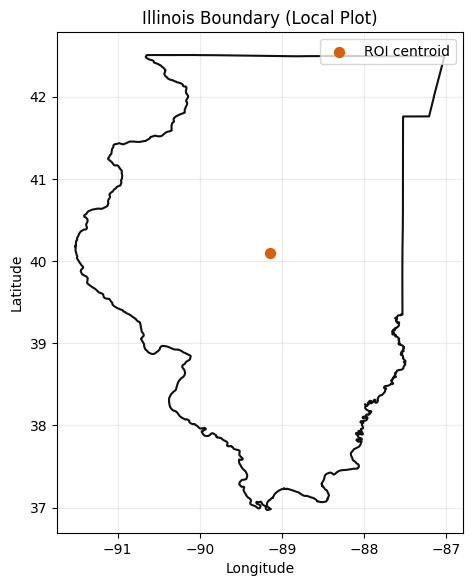

In [7]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))
draw_illinois_boundary(ax, color="#111111", linewidth=1.5)
if np.isfinite(center_lon) and np.isfinite(center_lat):
    ax.scatter([center_lon], [center_lat], s=50, color="#d95f02", label="ROI centroid")
ax.set_title("Illinois Boundary (Local Plot)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal", adjustable="box")
if np.isfinite(center_lon) and np.isfinite(center_lat):
    ax.legend(loc="upper right")
ax.grid(alpha=0.25)
plt.show()


## 2. Build sample points and prepare labels (H_TA filtering + Y_TA labels)
- Filter source: `spam2020V2r0_global_H_TA.csv`
- Conditions: `MAIZ_A >= MAIZ_AREA_MIN_HA`
- Label source: `MAIZ_A` from `spam2020V2r0_global_Y_TA.csv` (yield)
- Only retain points that can find corresponding labels in `Y_TA`


In [8]:
def resolve_spam_csv(filename: str) -> Path:
    candidates = [
        Path(f"spam2020V2r0_global_yield/{filename}"),
        Path(f"../spam2020V2r0_global_yield/{filename}"),
        Path(f"../../spam2020V2r0_global_yield/{filename}"),
    ]
    for p in candidates:
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(f"Cannot find SPAM csv: {filename}")


def match_series(series: pd.Series, target: str) -> pd.Series:
    s = series.astype(str).str.strip()
    t = target.strip()
    exact = s.str.casefold() == t.casefold()
    if exact.any():
        return exact
    return s.str.casefold().str.contains(t.casefold(), regex=False)


def apply_geo_filter(df_in: pd.DataFrame) -> pd.DataFrame:
    mask = pd.Series(True, index=df_in.index)
    if SPAM_COUNTRY_CODE:
        mask &= df_in["FIPS0"].astype(str).str.upper().eq(SPAM_COUNTRY_CODE)
    if SPAM_COUNTRY:
        mask &= match_series(df_in["ADM0_NAME"], SPAM_COUNTRY)
    if SPAM_STATE:
        mask &= match_series(df_in["ADM1_NAME"], SPAM_STATE)
    return df_in[mask].copy()


def apply_year_filter(df_in: pd.DataFrame, year: int) -> pd.DataFrame:
    year_text = df_in["year_data"].astype(str).str.strip()
    year_mask = year_text.eq(str(year)) | year_text.str.contains(str(year), regex=False)
    return df_in[year_mask].copy() if year_mask.any() else df_in.copy()


H_CSV = resolve_spam_csv("spam2020V2r0_global_H_TA.csv")
Y_CSV = resolve_spam_csv("spam2020V2r0_global_Y_TA.csv")

usecols = ["grid_code", "x", "y", "FIPS0", "ADM0_NAME", "ADM1_NAME", "year_data", "unit", SPAM_CROP_COL]

spam_h = pd.read_csv(H_CSV, usecols=usecols, encoding="utf-8-sig")
spam_h = apply_geo_filter(spam_h)
spam_h = spam_h.rename(columns={"x": "lon", "y": "lat", SPAM_CROP_COL: "maiz_area_ha", "unit": "area_unit"})
spam_h["grid_code"] = spam_h["grid_code"].astype(str)
spam_h["maiz_area_ha"] = pd.to_numeric(spam_h["maiz_area_ha"], errors="coerce")
spam_h = spam_h.replace([np.inf, -np.inf], np.nan).dropna(subset=["grid_code", "lon", "lat", "maiz_area_ha"])
spam_h = apply_year_filter(spam_h, LABEL_YEAR)
spam_h = spam_h[spam_h["maiz_area_ha"] >= MAIZ_AREA_MIN_HA].drop_duplicates(subset=["grid_code"])

spam_y = pd.read_csv(Y_CSV, usecols=usecols, encoding="utf-8-sig")
spam_y = apply_geo_filter(spam_y)
spam_y = spam_y.rename(columns={SPAM_CROP_COL: "label", "unit": "label_unit"})
spam_y["grid_code"] = spam_y["grid_code"].astype(str)
spam_y["label"] = pd.to_numeric(spam_y["label"], errors="coerce")
spam_y = spam_y.replace([np.inf, -np.inf], np.nan).dropna(subset=["grid_code", "label"])
spam_y = spam_y[spam_y["label"] > 0]
spam_y = apply_year_filter(spam_y, LABEL_YEAR)
spam_y = spam_y.drop_duplicates(subset=["grid_code"])

df = spam_h.merge(spam_y[["grid_code", "label", "label_unit"]], on="grid_code", how="inner").reset_index(drop=True)
if df.empty:
    raise RuntimeError("No joined points after filtering H_TA + Y_TA.")

label_units = sorted(set(df["label_unit"].dropna().astype(str).str.strip()))
LABEL_UNIT_STR = label_units[0] if label_units else "unknown"

print(f"label rows={len(df)}")
print(df[["lon", "lat", "maiz_area_ha", "label"]].describe().T)
df = df.sort_values(["lat", "lon"]).reset_index(drop=True)

print(f"Selected Illinois points: {len(df)}")
print(f"Buffer (m): {BUFFER_M}, Label year: {LABEL_YEAR}")

# Build export point specs once and reuse later
spatials = [PointBuffer(lon=float(r.lon), lat=float(r.lat), buffer_m=BUFFER_M) for r in df.itertuples(index=False)]
point_names = [f"p{i:05d}" for i in range(len(spatials))]

df.head()


label rows=991
              count         mean         std        min        25%        50%  \
lon           991.0   -89.115918    0.867297   -91.2917   -89.7917   -89.1250   
lat           991.0    40.612218    0.962697    37.7917    39.8750    40.7083   
maiz_area_ha  991.0  3160.181837  420.232955  2502.0000  2821.4500  3145.4000   
label         991.0     9.551261    0.559524     7.1000     9.5000     9.7000   

                    75%        max  
lon            -88.4583   -87.5417  
lat             41.2917    42.4583  
maiz_area_ha  3412.4000  4593.0000  
label            9.8000    11.8000  
Selected Illinois points: 991
Buffer (m): 2000, Label year: 2020


,grid_code,lon,lat,FIPS0,ADM0_NAME,ADM1_NAME,area_unit,maiz_area_ha,year_data,label,label_unit
0,2705420,-88.2917,37.7917,US,United States of America,Illinois,ha,4089.1,avg(2019-2021),11.8,mt/ha
1,2705421,-88.2083,37.7917,US,United States of America,Illinois,ha,4351.8,avg(2019-2021),11.8,mt/ha
2,2701101,-88.2083,37.8750,US,United States of America,Illinois,ha,4248.7,avg(2019-2021),11.8,mt/ha
3,2692460,-88.2917,38.0417,US,United States of America,Illinois,ha,2502.7,avg(2019-2021),9.9,mt/ha
4,2692462,-88.1250,38.0417,US,United States of America,Illinois,ha,2661.5,avg(2019-2021),9.8,mt/ha


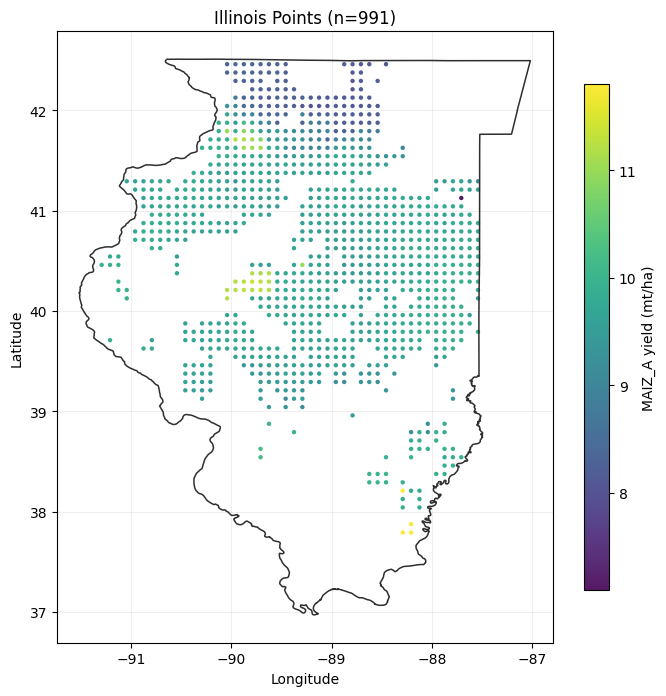

In [9]:
fig, ax = plt.subplots(figsize=(8.0, 8.0))
draw_illinois_boundary(ax, color="#2f2f2f", linewidth=1.1)

sc = ax.scatter(
    df["lon"],
    df["lat"],
    c=df["label"],
    s=10,
    cmap="viridis",
    alpha=0.9,
    linewidths=0,
)

cbar = fig.colorbar(sc, ax=ax, shrink=0.82)
cbar.set_label(f"{SPAM_CROP_COL} yield ({LABEL_UNIT_STR})")

ax.set_title(f"Illinois Points (n={len(df)})")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal", adjustable="box")
ax.grid(alpha=0.20)
plt.show()


## 2.1 Visualize the local input images and production labels

- No additional requests: directly read an exported `input_chw__*` patch from local `npz/json` artifacts.
- Automatically read the location from the group manifest and show the corresponding yield label on the Illinois map.


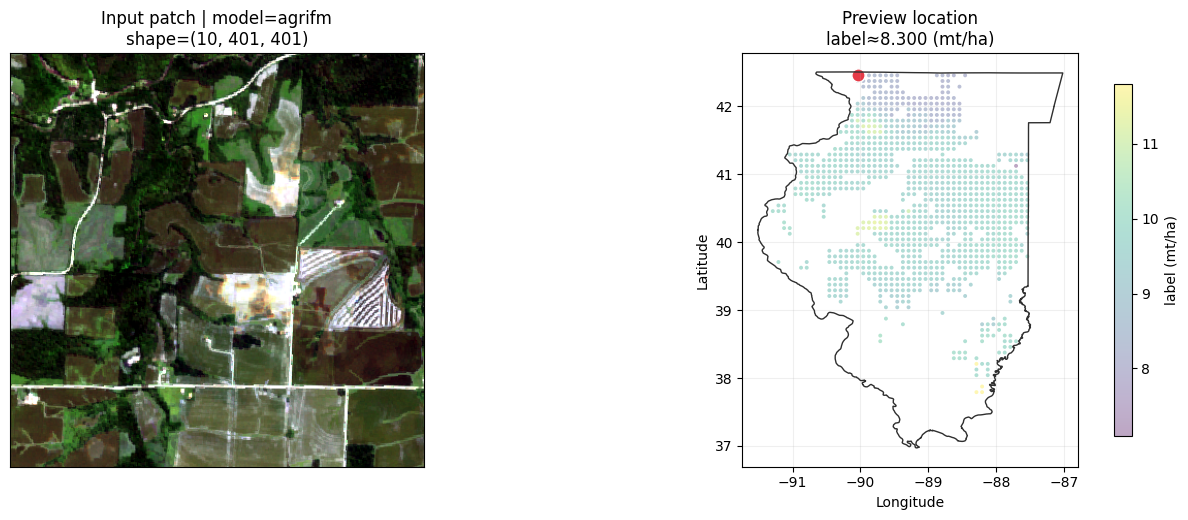

In [10]:
from examples.utils_demo import stretch_rgb, load_one_preview_patch, _resolve_preview_group_dirs

group_dirs_preview = _resolve_preview_group_dirs([
    Path("examples/exports/demo_all_models"),
    Path("../examples/exports/demo_all_models"),
    Path("../../examples/exports/demo_all_models"),
])

preview = load_one_preview_patch(group_dirs_preview, df)
if preview is None:
    print("No input_chw patch found. Run export first (save_inputs=True), or point to an existing demo_all_models folder.")
else:
    chw = preview["chw"]
    if chw.shape[0] >= 3:
        rgb = np.transpose(chw[:3], (1, 2, 0))
    else:
        mono = chw[0]
        rgb = np.stack([mono, mono, mono], axis=-1)
    rgb_show = stretch_rgb(rgb)

    fig, axes = plt.subplots(1, 2, figsize=(13.5, 5.3), width_ratios=[1.0, 1.15])

    axes[0].imshow(rgb_show)
    axes[0].set_title(f"Input patch | model={preview['model']}\nshape={tuple(chw.shape)}")
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    draw_illinois_boundary(axes[1], color="#2f2f2f", linewidth=1.0)
    sc_all = axes[1].scatter(df["lon"], df["lat"], c=df["label"], s=8, cmap="viridis", alpha=0.35, linewidths=0)
    if np.isfinite(preview["lon"]) and np.isfinite(preview["lat"]):
        axes[1].scatter([preview["lon"]], [preview["lat"]], s=90, color="#e63946", edgecolors="white", linewidths=1.0)
    cb = fig.colorbar(sc_all, ax=axes[1], shrink=0.85)
    cb.set_label(f"label ({LABEL_UNIT_STR})")
    axes[1].set_title(
        "Preview location\n"
        # f"group={preview['group']}, npz={preview['npz']}\n"
        f"label≈{preview['label']:.3f} ({LABEL_UNIT_STR})"
    )
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")
    axes[1].set_aspect("equal", adjustable="box")
    axes[1].grid(alpha=0.2)

    plt.tight_layout()
    plt.show()


## 3. Build an all-model export plan (single `export_batch` run)

- Discover all registered models from `MODEL_SPECS` (then try to import each via `get_embedder_cls`).
- Read each model's `describe()` (best effort) to preview capabilities / expected compatibility.
- Select a **single** export config (`backend`, `temporal`, `output`) for this run.
- Let `export_batch()` handle batching / parallelism; incompatible models can fail per-model with `continue_on_error=True`.


In [11]:
from examples.utils_demo import (
    _resolve_export_temporal,
    _safe_describe,
    _norm_backend_names,
    _temporal_mode_from_desc,
    _output_modes_from_desc,
)

# Concurrency hints (can be reduced to avoid GEE throttling)
worker_env = {
    "RS_EMBED_SATMAE_FETCH_WORKERS": "6",
    "RS_EMBED_SCALEMAE_FETCH_WORKERS": "6",
    "RS_EMBED_REMOTECLIP_FETCH_WORKERS": "6",
    "RS_EMBED_DOFA_FETCH_WORKERS": "6",
    "RS_EMBED_PRITHVI_FETCH_WORKERS": "6",
    "RS_EMBED_TERRAFM_FETCH_WORKERS": "6",
    "RS_EMBED_GSE_BATCH_WORKERS": "4",
    "RS_EMBED_COPERNICUS_BATCH_WORKERS": "4",
}
for k, v in worker_env.items():
    os.environ.setdefault(k, v)

EMBED_YEAR = int(os.getenv("EMBED_YEAR", "2019"))
EMBED_START = os.getenv("EMBED_START", "2019-06-01")
EMBED_END = os.getenv("EMBED_END", "2019-08-31")
MODEL_INCLUDE = [s.strip().lower() for s in os.getenv("MODEL_INCLUDE", "").split(",") if s.strip()]
MODEL_EXCLUDE = {s.strip().lower() for s in os.getenv("MODEL_EXCLUDE", "").split(",") if s.strip()}
MAX_MODELS = int(os.getenv("MAX_MODELS", "0"))

EXPORT_ROOT = Path(os.getenv("EXPORT_ROOT", "examples/exports/demo_all_models"))
EXPORT_ROOT.mkdir(parents=True, exist_ok=True)

# Single export config (same settings for all models in this run)
EXPORT_BACKEND = os.getenv("EXPORT_BACKEND", "gee").strip().lower()
EXPORT_TEMPORAL_MODE = os.getenv("EXPORT_TEMPORAL_MODE", "range").strip().lower()
EXPORT_OUTPUT_MODE = os.getenv("EXPORT_OUTPUT_MODE", "pooled").strip().lower()

EXPORT_TEMPORAL_MODE, EXPORT_TEMPORAL = _resolve_export_temporal(
    EXPORT_TEMPORAL_MODE,
    TemporalSpec,
    EMBED_YEAR,
    EMBED_START,
    EMBED_END,
)
EXPORT_OUTPUT_MODE = "grid" if EXPORT_OUTPUT_MODE == "grid" else "pooled"
EXPORT_OUTPUT = OutputSpec.grid(scale_m=10) if EXPORT_OUTPUT_MODE == "grid" else OutputSpec.pooled()

model_ids = sorted(MODEL_SPECS.keys())
if MODEL_INCLUDE:
    model_ids = [m for m in model_ids if m in set(MODEL_INCLUDE)]
if MODEL_EXCLUDE:
    model_ids = [m for m in model_ids if m not in MODEL_EXCLUDE]
if MAX_MODELS > 0:
    model_ids = model_ids[:MAX_MODELS]

rows = []
EXPORT_MODELS = []
for m in model_ids:
    desc, err = _safe_describe(m, get_embedder_cls)
    if err is not None:
        rows.append({
            "model": m,
            "status": "skip_import_error",
            "type": None,
            "declared_backend": None,
            "declared_temporal_mode": None,
            "declared_output": None,
            "error": err,
        })
        continue

    EXPORT_MODELS.append(m)
    rows.append({
        "model": m,
        "status": "planned",
        "type": str(desc.get("type", "")),
        "declared_backend": ",".join(_norm_backend_names(desc.get("backend"))) or None,
        "declared_temporal_mode": _temporal_mode_from_desc(desc),
        "declared_output": ",".join(_output_modes_from_desc(desc)) or None,
        "error": None,
    })

plan_df = pd.DataFrame(rows).sort_values(["status", "model"], na_position="last").reset_index(drop=True)
print(f"catalog models: {len(MODEL_SPECS)}")
print(f"selected models: {len(model_ids)}")
print(f"planned models: {len(EXPORT_MODELS)}")
print("single export config:", {
    "backend": EXPORT_BACKEND,
    "temporal_mode": EXPORT_TEMPORAL_MODE,
    "output_mode": EXPORT_OUTPUT_MODE,
    "export_root": str(EXPORT_ROOT),
})


catalog models: 18
selected models: 18
planned models: 17
single export config: {'backend': 'gee', 'temporal_mode': 'range', 'output_mode': 'pooled', 'export_root': 'examples/exports/demo_all_models'}


## 3.1 Inspect the model plan and chosen single export config


In [12]:
plan_df.head(50)


,model,status,type,declared_backend,declared_temporal_mode,declared_output,error
0,agrifm,planned,on_the_fly,gee,None,"pooled,grid",None
1,anysat,planned,on_the_fly,gee,range,"pooled,grid",None
2,copernicus_embed,planned,precomputed,"auto,local",ignored,"pooled,grid",None
3,dofa,planned,on_the_fly,gee,range,"pooled,grid",None
4,dynamicvis,planned,on_the_fly,gee,range,"pooled,grid",None
5,fomo,planned,on_the_fly,gee,range,"pooled,grid",None
6,galileo,planned,on_the_fly,gee,range,"pooled,grid",None
7,gse_annual,planned,precomputed,gee,year,"grid,pooled",None
8,prithvi_eo_v2_s2_6b,planned,onthefly,gee,None,"pooled,grid",None
9,remoteclip_s2rgb,planned,on_the_fly,gee,range,"pooled,grid",None


## 4. Export embeddings with one `export_batch()` call

- Export directly into `EXPORT_ROOT` (flat point files: `p00000.npz/json`, ...).
- `export_batch()` handles chunking / worker parallelism internally.
- Keep `continue_on_error=True` so incompatible models fail per-point/per-model instead of stopping the run.


In [14]:
SAVE_INPUTS = bool(int(os.getenv("SAVE_INPUTS", "1")))
SAVE_EMBEDDINGS = bool(int(os.getenv("SAVE_EMBEDDINGS", "1")))
SAVE_MANIFEST = True
CHUNK_SIZE = int(os.getenv("EXPORT_CHUNK_SIZE", "8"))
NUM_WORKERS = int(os.getenv("EXPORT_NUM_WORKERS", "4"))

has_existing_points = EXPORT_ROOT.exists() and any(EXPORT_ROOT.glob("p*.npz"))
has_existing_manifest = (EXPORT_ROOT / "_all_points_manifest.json").exists()
SKIP_EXPORT_BATCH = bool(int(os.getenv("SKIP_EXPORT_BATCH", "1" if (has_existing_points or has_existing_manifest) else "0")))

run_rows = []
if SKIP_EXPORT_BATCH:
    print(f"SKIP_EXPORT_BATCH=1 -> reuse existing exports under: {EXPORT_ROOT}")
else:
    if len(df) == 0:
        raise RuntimeError("No points to export.")
    if not EXPORT_MODELS:
        raise RuntimeError("No planned models to export.")

    t0 = time.time()
    print(f"Exporting {len(spatials)} points x {len(EXPORT_MODELS)} models -> {EXPORT_ROOT}")
    print("backend=", EXPORT_BACKEND, "temporal_mode=", EXPORT_TEMPORAL_MODE, "output_mode=", EXPORT_OUTPUT_MODE)

    manifests = export_batch(
        out_dir=str(EXPORT_ROOT),
        names=point_names,
        spatials=spatials,
        temporal=EXPORT_TEMPORAL,
        models=EXPORT_MODELS,
        output=EXPORT_OUTPUT,
        backend=EXPORT_BACKEND,
        save_inputs=SAVE_INPUTS,
        save_embeddings=SAVE_EMBEDDINGS,
        save_manifest=SAVE_MANIFEST,
        chunk_size=CHUNK_SIZE,
        num_workers=NUM_WORKERS,
        resume=True,
        continue_on_error=True,
        show_progress=True,
    )

    (EXPORT_ROOT / "_all_points_manifest.json").write_text(
        json.dumps(manifests, ensure_ascii=False, indent=2), encoding="utf-8"
    )
    export_request_json = {
        "backend": EXPORT_BACKEND,
        "temporal_mode": EXPORT_TEMPORAL_MODE,
        "temporal": None if EXPORT_TEMPORAL is None else {
            "mode": EXPORT_TEMPORAL.mode,
            "year": getattr(EXPORT_TEMPORAL, "year", None),
            "start": getattr(EXPORT_TEMPORAL, "start", None),
            "end": getattr(EXPORT_TEMPORAL, "end", None),
        },
        "output_mode": EXPORT_OUTPUT_MODE,
        "models": EXPORT_MODELS,
    }
    (EXPORT_ROOT / "_export_request.json").write_text(
        json.dumps(export_request_json, ensure_ascii=False, indent=2), encoding="utf-8"
    )

    dt = time.time() - t0
    run_rows.append({
        "backend": EXPORT_BACKEND,
        "temporal_mode": EXPORT_TEMPORAL_MODE,
        "output_mode": EXPORT_OUTPUT_MODE,
        "n_models": len(EXPORT_MODELS),
        "n_points": len(spatials),
        "n_manifests": len(manifests),
        "sec": round(float(dt), 2),
    })

run_df = pd.DataFrame(run_rows)
run_df


SKIP_EXPORT_BATCH=1 -> reuse existing exports under: examples/exports/demo_all_models


""


## 4.1 Export status summary (flat export dir; point/model failures, partials)


In [16]:
from examples.utils_demo import _point_manifest_has_issue, _load_point_manifests_flat, _safe_point_index

point_manifests = _load_point_manifests_flat(EXPORT_ROOT)
failed_point_indices = []
partial_n = 0
for pm in point_manifests:
    if not isinstance(pm, dict):
        continue

    st = str(pm.get("status", "")).lower()
    partial_n += int(st == "partial")

    if not _point_manifest_has_issue(pm, include_partial=False):
        continue
    i = _safe_point_index(pm)
    if i is not None:
        failed_point_indices.append(i)

failed_point_indices = sorted(set(failed_point_indices))
status_df = pd.DataFrame([
    {
        "export_root": str(EXPORT_ROOT),
        "n_points": len(point_manifests),
        "failed": len(failed_point_indices),
        "partial": partial_n,
        "n_npz": len(list(EXPORT_ROOT.glob("p*.npz"))) if EXPORT_ROOT.exists() else 0,
    }
])
status_df


,export_root,n_points,failed,partial,n_npz
0,examples/exports/demo_all_models,991,991,991,991


## 4.3 Inspect one exported file (read + summary + exact input visualization)


Inspecting: examples/exports/demo_all_models/p00000.npz
=== Manifest summary ===
npz_path: None
backend: gee
spatial: {'lon': -88.2917, 'lat': 37.7917, 'buffer_m': 2000, 'crs': 'EPSG:4326'}
temporal: {'mode': 'range', 'year': '<function TemporalSpec.year at 0x152cae71e2a0>', 'start': '2019-06-01', 'end': '2019-08-31'}
npz_keys: ['input_chw__agrifm', 'input_chw__dynamicvis', 'input_chw__fomo', 'input_chw__prithvi_eo_v2_s2_6b', 'embedding__agrifm', 'embedding__anysat', 'embedding__dofa', 'embedding__fomo', 'embedding__galileo', 'embedding__prithvi_eo_v2_s2_6b', 'embedding__remoteclip_s2rgb', 'embedding__satmae_rgb', 'embedding__scalemae_rgb', 'embedding__terrafm_b', 'embedding__terramind', 'embedding__thor_1_0_base', 'embedding__wildsat']

=== model -> input key ===
agrifm: input_chw__agrifm
anysat: input_chw__agrifm
copernicus_embed: None
dofa: None
dynamicvis: input_chw__dynamicvis
fomo: input_chw__fomo
galileo: input_chw__agrifm
gse_annual: None
prithvi_eo_v2_s2_6b: input_chw__prithvi

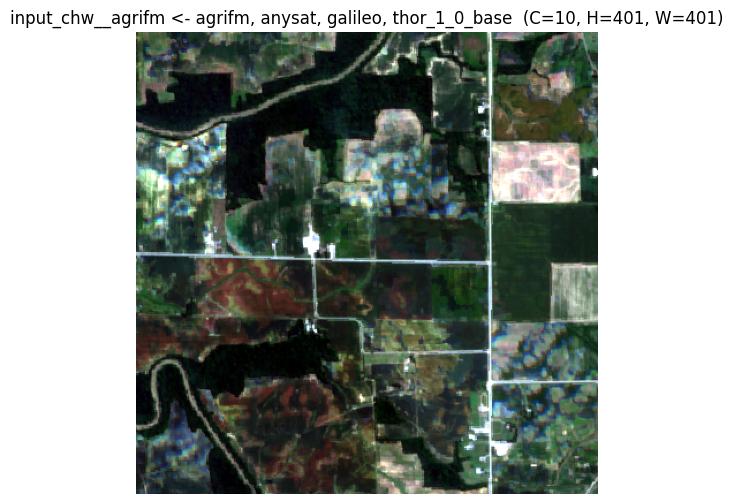

input_chw__dynamicvis <- dynamicvis, remoteclip_s2rgb, wildsat shape=(3, 401, 401) dtype=float32 min=146 max=5.37e+03


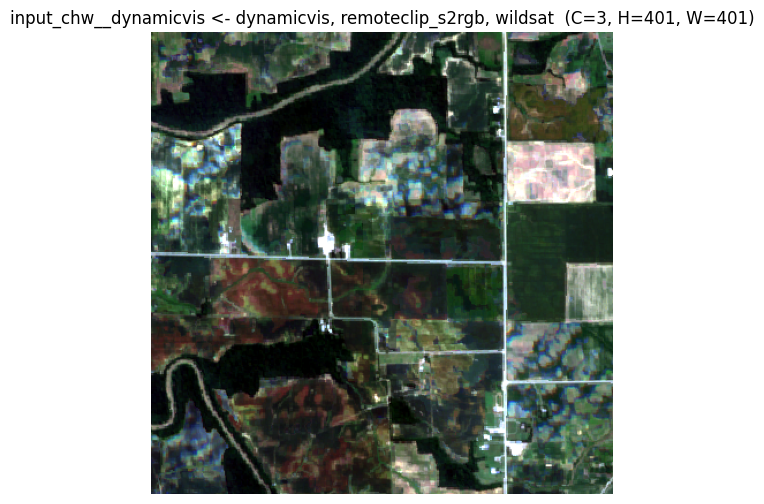

input_chw__fomo <- fomo, terrafm_b, terramind shape=(12, 401, 401) dtype=float32 min=146 max=6.27e+03


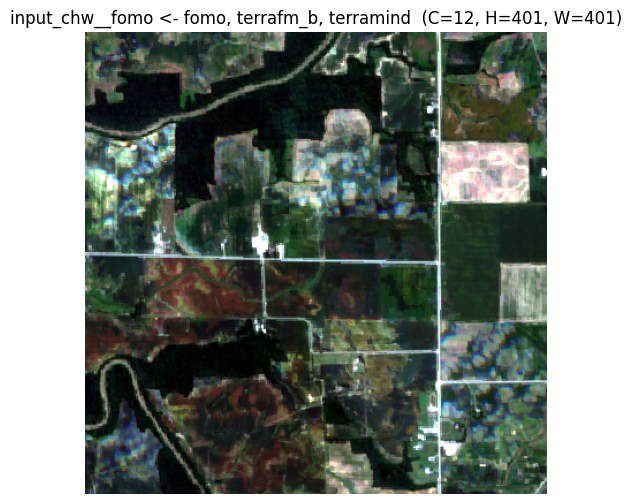

input_chw__prithvi_eo_v2_s2_6b <- prithvi_eo_v2_s2_6b shape=(6, 401, 401) dtype=float32 min=146 max=5.91e+03


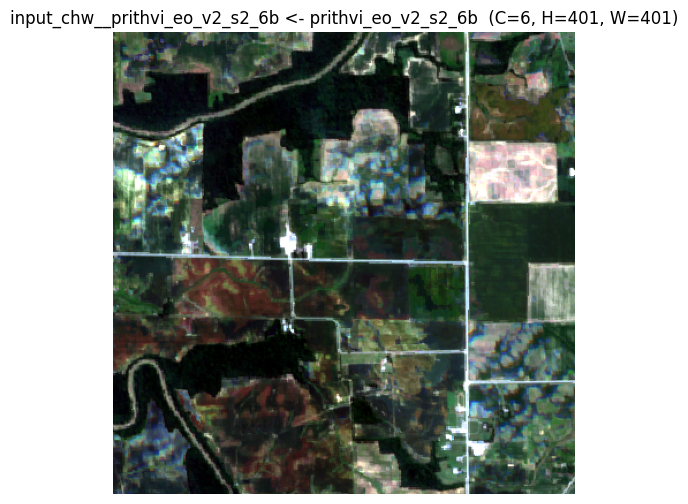

In [17]:
from examples.utils_demo import _iter_export_search_dirs, _first_npz_in_dir

example_npz = next(
    (
        npz
        for folder in _iter_export_search_dirs(EXPORT_ROOT)
        for npz in [_first_npz_in_dir(folder)]
        if npz is not None
    ),
    None,
)

if example_npz is None:
    print("No exported npz found under", EXPORT_ROOT)
else:
    print("Inspecting:", example_npz)
    manifest, z = inspect_export_npz(example_npz)


## 5. Prepare export folder for downstream loading (flat export, with legacy grouped fallback)


In [18]:
EXPORT_ROOT_CANDIDATES = [
    EXPORT_ROOT,
    Path("/u/dingqi2/workspace/foundation/examples/exports/demo_all_models"),
    Path("examples/exports/demo_all_models"),
]
EXPORT_ROOT = next((p for p in EXPORT_ROOT_CANDIDATES if p.exists()), EXPORT_ROOT_CANDIDATES[0])

flat_npz_count = len(list(EXPORT_ROOT.glob("p*.npz"))) if EXPORT_ROOT.exists() else 0
flat_json_count = len(list(EXPORT_ROOT.glob("p*.json"))) if EXPORT_ROOT.exists() else 0
legacy_group_dirs = sorted([p for p in EXPORT_ROOT.iterdir() if p.is_dir() and p.name.startswith("group")]) if EXPORT_ROOT.exists() else []

print(f"EXPORT_ROOT={EXPORT_ROOT}")
print(f"flat point files: npz={flat_npz_count}, json={flat_json_count}")
print(f"legacy group folders: {len(legacy_group_dirs)}")


EXPORT_ROOT=examples/exports/demo_all_models
flat point files: npz=991, json=991
legacy group folders: 0


In [20]:
from examples.utils_demo import _load_point_manifests_any

point_manifests_cov, manifest_mode = _load_point_manifests_any(EXPORT_ROOT)
model_stats = {}
for pm in point_manifests_cov:
    if not isinstance(pm, dict):
        continue
    for m in pm.get("models", []):
        if not isinstance(m, dict):
            continue
        model = str(m.get("model", "")).strip()
        if not model:
            continue
        st = str(m.get("status", pm.get("status", ""))).lower()
        rec = model_stats.setdefault(model, {"model": model, "n_points": 0, "ok": 0, "partial": 0, "failed": 0})
        rec["n_points"] += 1
        if st == "ok":
            rec["ok"] += 1
        elif st == "partial":
            rec["partial"] += 1
        elif st == "failed":
            rec["failed"] += 1

coverage_df = pd.DataFrame(model_stats.values())
if len(coverage_df) > 0:
    coverage_df["ok_rate"] = coverage_df["ok"] / coverage_df["n_points"].clip(lower=1)
    coverage_df = coverage_df.sort_values(["ok_rate", "ok", "model"], ascending=[False, False, True]).reset_index(drop=True)
print("manifest_mode=", manifest_mode, ", points=", len(point_manifests_cov))
coverage_df.head(30)


manifest_mode= flat_aggregate , points= 991


,model,n_points,ok,partial,failed,ok_rate
0,agrifm,991,991,0,0,1.0
1,anysat,991,991,0,0,1.0
2,dofa,991,991,0,0,1.0
3,fomo,991,991,0,0,1.0
4,galileo,991,991,0,0,1.0
5,prithvi_eo_v2_s2_6b,991,991,0,0,1.0
6,remoteclip_s2rgb,991,991,0,0,1.0
7,satmae_rgb,991,991,0,0,1.0
8,scalemae_rgb,991,991,0,0,1.0
9,terrafm_b,991,991,0,0,1.0


## 5. Load exported embeddings and assemble per-model feature matrices

- Align embeddings to current filtered points by `(lon, lat)`.
- Keep a per-model matrix `X_by_model[model]` with shape `(N_points, D)`.
- Missing rows remain `NaN` and will be masked per-model during regression.


In [22]:
from examples.utils_demo import point_key, to_feature_vector, _iter_export_points, _point_row_index, _iter_model_vectors

df_regression = df.copy().reset_index(drop=True)
p2i = {point_key(r.lon, r.lat): i for i, r in enumerate(df_regression.itertuples(index=False))}
N = len(df_regression)

vecs_by_model: dict[str, dict[int, np.ndarray]] = {}
model_dim_error: set[str] = set()
load_modes_seen = set()
items_seen = 0

for pm, npz_path, load_mode in _iter_export_points(EXPORT_ROOT):
    load_modes_seen.add(load_mode)
    items_seen += 1

    di = _point_row_index(pm, p2i)
    if di is None or not npz_path.exists():
        continue

    with np.load(npz_path, allow_pickle=False) as bundle:
        for model, vec in _iter_model_vectors(bundle, pm):
            slot = vecs_by_model.setdefault(model, {})
            prev = slot.get(di)
            if prev is not None and int(prev.shape[0]) != int(vec.shape[0]):
                model_dim_error.add(model)
                continue
            slot[di] = vec

X_by_model = {}
embed_rows = []

for model, vec_map in sorted(vecs_by_model.items()):
    if model in model_dim_error or not vec_map:
        continue

    dims = sorted({int(v.shape[0]) for v in vec_map.values()})
    if len(dims) != 1:
        continue

    d = dims[0]
    X = np.full((N, d), np.nan, dtype=np.float32)
    for i, vec in vec_map.items():
        X[int(i)] = vec

    valid_rows = int(np.isfinite(X).all(axis=1).sum())
    coverage = float(valid_rows / max(1, N))

    X_by_model[model] = X
    embed_rows.append({"model": model, "dim": d, "n_valid_rows": valid_rows, "coverage": coverage})

embed_df = pd.DataFrame(embed_rows).sort_values("coverage", ascending=False).reset_index(drop=True)
print(f"export items scanned: {items_seen}")
print(f"load modes: {sorted(load_modes_seen)}")
print(f"usable models: {len(X_by_model)}")
embed_df.head(20)


export items scanned: 991
load modes: ['flat_aggregate']
usable models: 13


,model,dim,n_valid_rows,coverage
0,agrifm,1024,991,1.0
1,anysat,768,991,1.0
2,dofa,768,991,1.0
3,fomo,768,991,1.0
4,galileo,128,991,1.0
5,prithvi_eo_v2_s2_6b,768,991,1.0
6,remoteclip_s2rgb,512,991,1.0
7,satmae_rgb,1024,991,1.0
8,scalemae_rgb,1024,991,1.0
9,terrafm_b,768,991,1.0


## 6. Crop yield regression (2019 embeddings -> 2020 yield)

- Regressors:
  - linear baseline: `StandardScaler + Ridge`
  - nonlinear baseline: `RandomForestRegressor`
- Regression is run **per model** using rows where that model has valid embeddings.
- The leaderboard is reported for `PRIMARY_REGRESSOR` (`rf` by default).


In [23]:
if not X_by_model:
    raise RuntimeError("No usable embeddings found in export folder.")


def rmse_compat(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def build_ridge():
    return make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=42))


def build_rf():
    return RandomForestRegressor(
        n_estimators=150,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=2,
        max_features="sqrt",
    )


regressors = {"ridge": build_ridge, "rf": build_rf}
if PRIMARY_REGRESSOR not in regressors:
    raise ValueError(f"Unsupported PRIMARY_REGRESSOR={PRIMARY_REGRESSOR!r}")

y = df_regression["label"].to_numpy(dtype=np.float32)
reg_rows = []
pred_by_model_all = {}

for learner, reg_builder in regressors.items():
    for model, X in X_by_model.items():
        valid_mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
        valid_idx = np.where(valid_mask)[0]

        if len(valid_idx) < max(8, MIN_MODEL_SAMPLES):
            reg_rows.append(
                {
                    "learner": learner,
                    "model": model,
                    "r2": np.nan,
                    "rmse": np.nan,
                    "mae": np.nan,
                    "n_total": int(len(valid_idx)),
                    "n_train": 0,
                    "n_test": 0,
                    "note": f"skip: too few valid rows ({len(valid_idx)})",
                }
            )
            continue

        idx_tr, idx_te = train_test_split(valid_idx, test_size=TEST_SIZE, random_state=42)

        try:
            reg = reg_builder()
            reg.fit(X[idx_tr], y[idx_tr])
            pred = reg.predict(X[idx_te]).astype(np.float32)

            reg_rows.append(
                {
                    "learner": learner,
                    "model": model,
                    "r2": r2_score(y[idx_te], pred),
                    "rmse": rmse_compat(y[idx_te], pred),
                    "mae": mean_absolute_error(y[idx_te], pred),
                    "n_total": int(len(valid_idx)),
                    "n_train": int(len(idx_tr)),
                    "n_test": int(len(idx_te)),
                    "note": "ok",
                }
            )

            pred_by_model_all[(learner, model)] = {
                "idx_test": idx_te,
                "y_true": y[idx_te],
                "y_pred": pred,
            }
        except Exception as e:
            reg_rows.append(
                {
                    "learner": learner,
                    "model": model,
                    "r2": np.nan,
                    "rmse": np.nan,
                    "mae": np.nan,
                    "n_total": int(len(valid_idx)),
                    "n_train": int(len(idx_tr)),
                    "n_test": int(len(idx_te)),
                    "note": f"failed: {type(e).__name__}: {e}",
                }
            )

reg_df_all = pd.DataFrame(reg_rows).sort_values(["learner", "r2"], ascending=[True, False], na_position="last")
reg_df = (
    reg_df_all[reg_df_all["learner"] == PRIMARY_REGRESSOR]
    .drop(columns=["learner"])
    .sort_values("r2", ascending=False, na_position="last")
    .reset_index(drop=True)
)

pred_by_model = {
    m: pred_by_model_all[(PRIMARY_REGRESSOR, m)]
    for m in reg_df["model"].tolist()
    if (PRIMARY_REGRESSOR, m) in pred_by_model_all
}

summary_by_learner = (
    reg_df_all.dropna(subset=["r2"])
    .groupby("learner", as_index=False)
    .agg(best_r2=("r2", "max"), mean_r2=("r2", "mean"), best_rmse=("rmse", "min"), n_models=("model", "count"))
    .sort_values("best_r2", ascending=False)
)

print(f"PRIMARY_REGRESSOR={PRIMARY_REGRESSOR}, MIN_MODEL_SAMPLES={MIN_MODEL_SAMPLES}, TEST_SIZE={TEST_SIZE}")
summary_by_learner


PRIMARY_REGRESSOR=rf, MIN_MODEL_SAMPLES=80, TEST_SIZE=0.25


,learner,best_r2,mean_r2,best_rmse,n_models
0,rf,0.310044,0.166660,0.472467,13
1,ridge,0.218629,-0.562232,0.502793,13


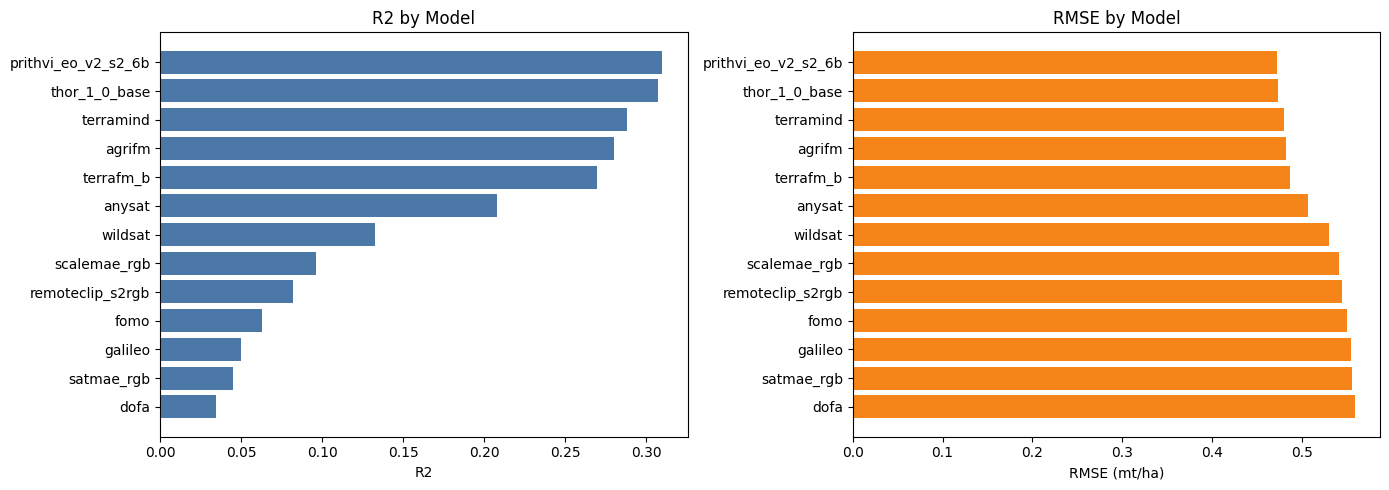

In [24]:
valid_r2 = reg_df.dropna(subset=["r2"]).copy()
valid_rmse = reg_df.dropna(subset=["rmse"]).copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if len(valid_r2) > 0:
    plot_df = valid_r2.sort_values("r2", ascending=True)
    axes[0].barh(plot_df["model"], plot_df["r2"], color="#4c78a8")
axes[0].set_title("R2 by Model")
axes[0].set_xlabel("R2")

if len(valid_rmse) > 0:
    plot_df2 = valid_rmse.sort_values("rmse", ascending=False)
    axes[1].barh(plot_df2["model"], plot_df2["rmse"], color="#f58518")
axes[1].set_title("RMSE by Model")
axes[1].set_xlabel(f"RMSE ({LABEL_UNIT_STR})")

plt.tight_layout()
plt.show()


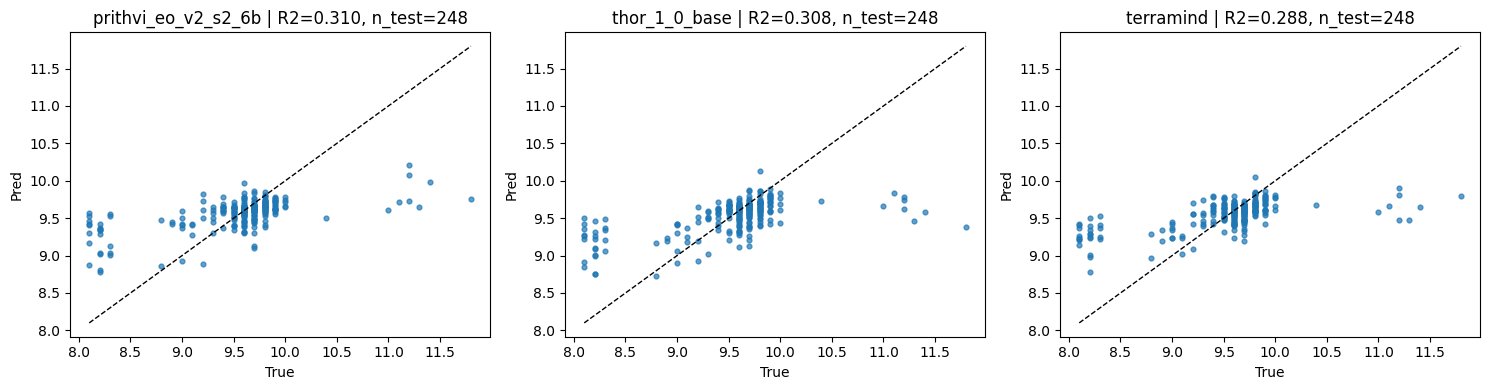

In [25]:
top_models = reg_df.dropna(subset=["r2"]).head(3)["model"].tolist()
if not top_models:
    print("No valid regression result to plot.")
else:
    fig, axes = plt.subplots(1, len(top_models), figsize=(5 * len(top_models), 4))
    if len(top_models) == 1:
        axes = [axes]

    for ax, model in zip(axes, top_models):
        pred_obj = pred_by_model[model]
        y_true = pred_obj["y_true"]
        y_pred = pred_obj["y_pred"]

        ax.scatter(y_true, y_pred, s=12, alpha=0.7)
        lo = float(min(y_true.min(), y_pred.min()))
        hi = float(max(y_true.max(), y_pred.max()))
        ax.plot([lo, hi], [lo, hi], "k--", linewidth=1)

        row = reg_df.set_index("model").loc[model]
        ax.set_title(f"{model} | R2={float(row['r2']):.3f}, n_test={int(row['n_test'])}")
        ax.set_xlabel("True")
        ax.set_ylabel("Pred")

    plt.tight_layout()
    plt.show()


## 7. Residuals of the best model's test set


In [26]:
valid_reg = reg_df.dropna(subset=["r2"]).copy()
if len(valid_reg) == 0:
    print("No valid regression result.")
else:
    best_model = valid_reg.iloc[0]["model"]
    best_pred_obj = pred_by_model[best_model]

    idx_te_best = best_pred_obj["idx_test"]
    best_pred = best_pred_obj["y_pred"]

    test_df = df_regression.iloc[idx_te_best].copy()
    test_df["pred"] = best_pred
    test_df["resid"] = test_df["pred"] - test_df["label"]

    print("Best model:", best_model)
    print("Best model test rows:", len(test_df))
    test_df.head()


Best model: prithvi_eo_v2_s2_6b
Best model test rows: 248


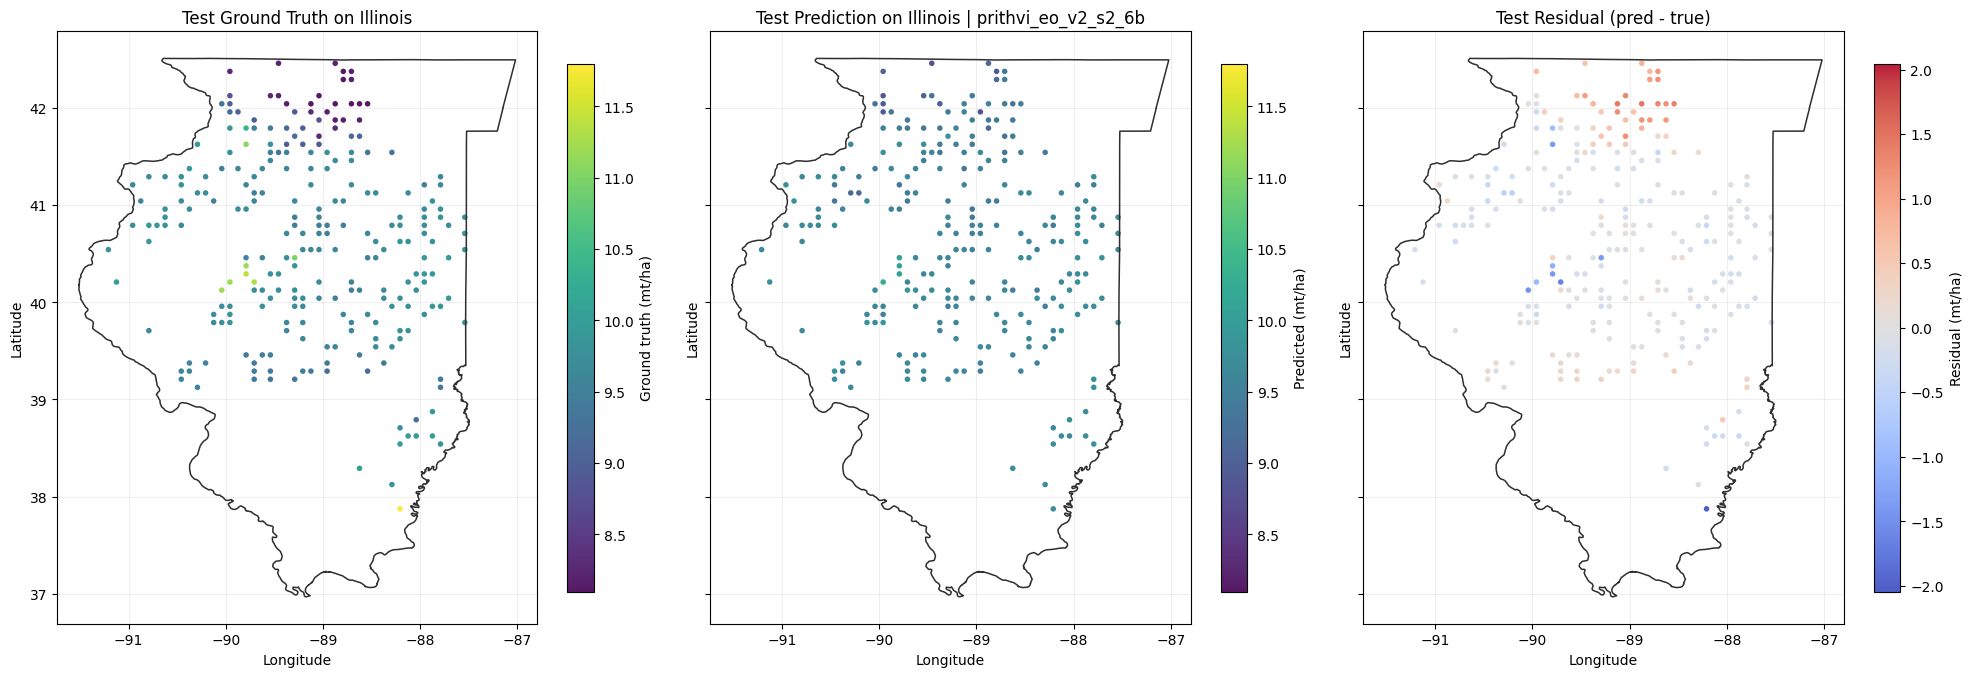

In [27]:
if "test_df" in globals():
    value_min = float(min(test_df["label"].min(), test_df["pred"].min()))
    value_max = float(max(test_df["label"].max(), test_df["pred"].max()))
    rmax = float(np.nanmax(np.abs(test_df["resid"].to_numpy())))
    rmax = max(rmax, 1e-6)

    fig, axes = plt.subplots(1, 3, figsize=(20.0, 6.8), sharex=True, sharey=True)
    ax_gt, ax_pred, ax_res = axes

    draw_illinois_boundary(ax_gt, color="#2f2f2f", linewidth=1.1)
    draw_illinois_boundary(ax_pred, color="#2f2f2f", linewidth=1.1)
    draw_illinois_boundary(ax_res, color="#2f2f2f", linewidth=1.1)

    sc_gt = ax_gt.scatter(
        test_df["lon"],
        test_df["lat"],
        c=test_df["label"],
        s=16,
        cmap="viridis",
        vmin=value_min,
        vmax=value_max,
        alpha=0.9,
        linewidths=0,
    )
    cbar_gt = fig.colorbar(sc_gt, ax=ax_gt, shrink=0.82)
    cbar_gt.set_label(f"Ground truth ({LABEL_UNIT_STR})")
    ax_gt.set_title("Test Ground Truth on Illinois")

    sc_pred = ax_pred.scatter(
        test_df["lon"],
        test_df["lat"],
        c=test_df["pred"],
        s=16,
        cmap="viridis",
        vmin=value_min,
        vmax=value_max,
        alpha=0.9,
        linewidths=0,
    )
    cbar_pred = fig.colorbar(sc_pred, ax=ax_pred, shrink=0.82)
    cbar_pred.set_label(f"Predicted ({LABEL_UNIT_STR})")
    ax_pred.set_title(f"Test Prediction on Illinois | {best_model}")

    sc_res = ax_res.scatter(
        test_df["lon"],
        test_df["lat"],
        c=test_df["resid"],
        s=16,
        cmap="coolwarm",
        vmin=-rmax,
        vmax=rmax,
        alpha=0.9,
        linewidths=0,
    )
    cbar_res = fig.colorbar(sc_res, ax=ax_res, shrink=0.82)
    cbar_res.set_label(f"Residual ({LABEL_UNIT_STR})")
    ax_res.set_title("Test Residual (pred - true)")

    for ax in axes:
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_aspect("equal", adjustable="box")
        ax.grid(alpha=0.20)

    plt.tight_layout()
    plt.show()


## 8. Summary

This reconstructed notebook supports:
- **All registered models (best effort)** with a single `export_batch()` run.
- One shared export config per run:
  - `EXPORT_BACKEND` (`gee` / `local` / `auto`)
  - `EXPORT_TEMPORAL_MODE` (`range` / `year` / `none`)
  - `EXPORT_OUTPUT_MODE` (`pooled` / `grid`)
- End-to-end crop-yield regression with per-model availability masking.
- Backward-compatible loading for older grouped export folders (`group*`).

Useful environment toggles:
- `SKIP_EXPORT_BATCH=1` to reuse local artifacts.
- `MODEL_INCLUDE`, `MODEL_EXCLUDE`, `MAX_MODELS` to narrow the run.
- `EXPORT_BACKEND`, `EXPORT_TEMPORAL_MODE`, `EXPORT_OUTPUT_MODE` to set one export config.
- `EMBED_YEAR`, `EMBED_START`, `EMBED_END` for temporal choices.
- `MIN_MODEL_SAMPLES`, `REG_TEST_SIZE`, `PRIMARY_REGRESSOR` for regression behavior.
